# How training works
A notebook shows how the training process is done.

In [1]:
import torch
from torchvision import transforms, models
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import DataLoader

import time
from helpers import *
from style_subnet import Style_Subnet
from enhance_subnet import Enhance_Subnet
from refine_subnet import Refine_Subnet
from loss_utils import LossNetwork, getLosses
from collections import namedtuple

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    #torch.set_default_tensor_type('torch.FloatTensor')

# Dataset
data_root = 'stylized_imgs/0_Original'

content_transN = transforms.Compose([transforms.Resize(480),
                                    transforms.CenterCrop(480),
                                    transforms.Resize(256),
                                    transforms.ToTensor(),
                                    tensor_normalizer()])

train_dataset = datasets.ImageFolder(root=data_root, transform=content_transN)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)    

print("Loading VGG..")
vgg = models.vgg19(pretrained=True).features.to(device).eval()
loss_network = LossNetwork(vgg).to(device).eval()
del vgg

Loading VGG..


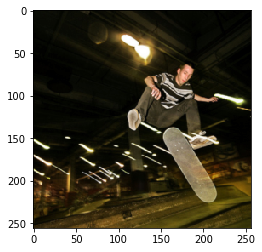

tensor(-2.1179)
tensor(2.6400)


In [24]:
x, _ = next(iter(train_loader)) 
imshow(x.detach())
print(x.min())
print(x.max())

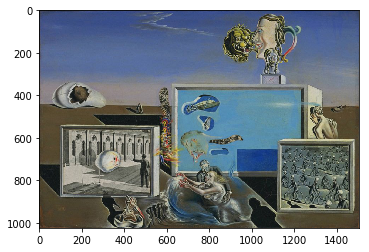

In [21]:
style_root = 'ref_style_images/Dali-illumined-pleasure-1929.jpg'

style256 = load_image(style_root, device, 256)

style512 = load_image(style_root, device, 512)

style1024 = load_image(style_root, device, 1024)

style_name = 'pierre'

imshow(style1024)

In [22]:
""" Before training, compute the features of every resolution of the style image """

print("Computing style features..")
with torch.no_grad(): 
    style_loss_features_256 = loss_network(style256, 'style')
    style_loss_features_512 = loss_network(style512, 'style')
    style_loss_features_1024 = loss_network(style1024, 'style')
    
gram_style_256 = [gram_matrix(y) for y in style_loss_features_256]
gram_style_512 = [gram_matrix(y) for y in style_loss_features_512]
gram_style_1024 = [gram_matrix(y) for y in style_loss_features_1024]


assert style_loss_features_256[0].requires_grad == False, "Style_features requires grad!"
assert gram_style_256[0].requires_grad == False, "gram requires grad!"

Computing style features..


# Define all Net & Module
During training, empirical feedback is that:  
* **Roles of Subnets:**  
  * Style Subnet: concentrates on first step stylization, which means: large texture and general color.
  * Enhance Subnet: learns more about the color distribution, even draws some color which $\hat{y_1}$ doesn't contain. Besides, it also clean up some "noisy texture" and put on some details strokes.
  * Refine Subnet: Further refine the $\hat{y_2}$, which means removing the local pixelization artifacts. Though, sometimes it is hard to obeserve it. Intuitively, it smooths the result.
* **Technical:**
  * Training three networks jointly requires different weight setting for both content- / style loss for all three network, which is totally different from training a single one's setting.
  * L_Block in Enhance net and channel number of each block is still ambiguous. I use the simplest structure (no L_Block in Enhance_Subenet and fewer channels for each block) for a faster training process.

In [23]:
""" Prepare Training """

mse_loss = torch.nn.MSELoss()
max_iterations = min(3000, len(train_dataset))


style_subnet = Style_Subnet().to(device)
enhance_subnet = Enhance_Subnet().to(device)
refine_subnet = Refine_Subnet().to(device)

In [24]:
# init optimizer
optimizer = torch.optim.Adam(list(style_subnet.parameters()) + 
                             list(enhance_subnet.parameters()) +
                             list(refine_subnet.parameters()), lr=LR)

In [25]:
print(style_name)
print(device)
print(max_iterations)
print(LR)

pierre
cuda
100
0.001


In [26]:
content_weight = [1, 1, 1]
style_weight = [8e5*0.6, 8e5*4*0.3, 8e5*0.2]
log_interval = 400

In [27]:
style_subnet.train().cuda()
enhance_subnet.train().cuda()
refine_subnet.train().cuda()

for epoch in range(EPOCH):
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0

    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        
        if (batch_id + 1) % 2000 == 0 and batch_id != 0:            
            LR = LR * 0.8
            print("---------------------LR decrease-----------------------")
            optimizer = Adam(list(style_subnet.parameters()) 
                             + list(enhance_subnet.parameters()) 
                             + list(refine_subnet.parameters()) , LR)

        optimizer.zero_grad()


        #--------------------------Style Subnet-------------------------#
        style_out, resized_img1 = style_subnet(x.to(device))

        s_content_loss, s_style_loss = getLosses(style_out, 
                                                 resized_img1,
                                                 content_weight[0], 
                                                 style_weight[0],
                                                 loss_network,
                                                 mse_loss,
                                                 gram_style_256)

        #--------------------------Enhance Subnet-------------------------#
        enhance_out, resized_img2 = enhance_subnet(style_out)

        e_content_loss, e_style_loss = getLosses(enhance_out, 
                                                resized_img2,
                                                content_weight[1], 
                                                style_weight[1],
                                                loss_network, 
                                                mse_loss,
                                                gram_style_512)
        #--------------------------Refine Subnet--------------------------#
        refine_out, resized_img3 = refine_subnet(enhance_out)

        r_content_loss, r_style_loss = getLosses(refine_out, 
                                                 resized_img3,
                                                 content_weight[2], 
                                                 style_weight[2],
                                                 loss_network,
                                                 mse_loss,
                                                 gram_style_1024) 

        #--------------------------Back Prop and update---------------------#



        total_loss = 1 * (s_content_loss + s_style_loss) \
                    + 0.5 * (e_content_loss + e_style_loss) \
                    + 0.25 * (r_content_loss + r_style_loss) 


        total_loss.backward()
        optimizer.step()

        agg_content_loss += (s_content_loss.item()+ e_content_loss.item() + r_content_loss.item())
        agg_style_loss += (s_style_loss.item() + e_style_loss.item() + r_style_loss.item())

        if (batch_id + 1) % log_interval == 0:
            mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.5f}\tstyle: {:.5f}\ttotal: {:.5f}".format(
                time.ctime(), epoch + 1, count, len(train_loader.dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)
            #agg_content_loss, agg_style_loss = 0., 0.
            print('\ns_content:{:.5f}, s_style:{:.5f}, en_content:{:.5f}, en_style:{:.5f}, re_content:{:.5f}, re_style:{:.5f}\n'.format(
                     s_content_loss, s_style_loss, e_content_loss, e_style_loss, r_content_loss, r_style_loss))
            imshow(x)
            imshow(style_out)
            imshow(enhance_out)
            imshow(refine_out)
        
        if (batch_id + 1) % 900 == 0:
            save_models('./CheckPoint/' + style_name, style_subnet, enhance_subnet, refine_subnet)

        #if part:
        if count > max_iterations:
            break
            
            
# save_models(style_name, style_subnet, enhance_subnet, refine_subnet)

In [47]:
save_models(style_name, style_subnet, enhance_subnet, refine_subnet)

Saving models...
